In [47]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

#Base dataset folder
base_path = os.path.join(os.getcwd(), '../dataset#1')
target_folders = ["circle", "diagonal_left", "diagonal_right", "horizontal", "vertical"]

#Output folder for augmented data
augmented_root = os.path.join(base_path, "augmented")
os.makedirs(augmented_root, exist_ok=True)

print("Base dataset :", base_path)
print("Augmented output :", augmented_root)

Base dataset : C:\Users\Theo\Desktop\GitHub\EuroFusion-AI\DataAugmentation\../dataset#1
Augmented output : C:\Users\Theo\Desktop\GitHub\EuroFusion-AI\DataAugmentation\../dataset#1\augmented


In [48]:
def jitter(x, sigma=0.1):
    return x + np.random.normal(0.0, sigma, size=x.shape)

def scaling(x, sigma=0.2):
    factor = np.random.normal(1.0, sigma, size=(x.shape[1],))
    return x * factor

def permutation(x, n_segments=5):
    idx = np.arange(len(x))
    split_points = np.linspace(0, len(x), n_segments + 1, dtype=int)
    segments = [idx[split_points[i]:split_points[i + 1]] for i in range(n_segments)]
    np.random.shuffle(segments)
    return x[np.concatenate(segments)]

def warping(x, sigma=0.2):
    orig_steps = np.arange(x.shape[0])
    random_factors = np.random.normal(1.0, sigma, size=x.shape[0])
    new_steps = orig_steps * random_factors
    warped = np.zeros_like(x)
    
    for i in range(x.shape[1]):
        cs = CubicSpline(orig_steps, x[:, i])
        warped[:, i] = cs(np.clip(new_steps, 0, x.shape[0] - 1))
    
    return warped

In [49]:
jitter_sigmas = [0.01, 0.03, 0.05]
scaling_sigmas = [0.05, 0.1, 0.2]
permutation_segments = [2, 4]
warping_sigmas = [0.1, 0.13]

for folder in target_folders:
    input_path = os.path.join(base_path, folder)
    output_path = os.path.join(augmented_root, folder)
    os.makedirs(output_path, exist_ok=True)

    file_list = glob.glob(os.path.join(input_path, "*.txt"))
    if not file_list:
        print(f"No files found in {folder}")
        continue

    for file_path in file_list:
        try:
            df = pd.read_csv(file_path, sep=",", header=None, comment="#")
            points = df.iloc[:, 6]
            coords = points.dropna().astype(str).str.split("/", expand=True).astype(float)
            coords.columns = ["x", "y", "z"]
            data = coords.to_numpy()
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        if data.ndim != 2 or data.shape[1] != 3 or len(data) < 3:
            print(f"Skipping {file_path} : invalid or incomplete coordinate data.")
            continue

        base_name = os.path.splitext(os.path.basename(file_path))[0]

        for sigma in jitter_sigmas:
            aug_data = jitter(data, sigma=sigma)
            np.savetxt(os.path.join(output_path, f"{base_name}_jitter_{sigma:.3f}.txt"),
                       aug_data, fmt="%.6f", delimiter=",")

        for sigma in scaling_sigmas:
            aug_data = scaling(data, sigma=sigma)
            np.savetxt(os.path.join(output_path, f"{base_name}_scaling_{sigma:.3f}.txt"),
                       aug_data, fmt="%.6f", delimiter=",")

        for n_seg in permutation_segments:
            aug_data = permutation(data, n_segments=n_seg)
            np.savetxt(os.path.join(output_path, f"{base_name}_permutation_{n_seg}.txt"),
                       aug_data, fmt="%.6f", delimiter=",")

        for sigma in warping_sigmas:
            aug_data = warping(data, sigma=sigma)
            np.savetxt(os.path.join(output_path, f"{base_name}_warping_{sigma:.3f}.txt"),
                       aug_data, fmt="%.6f", delimiter=",")

    print(f"Augmented data created for : {folder}")

Augmented data created for : circle
Augmented data created for : diagonal_left
Augmented data created for : diagonal_right
Augmented data created for : horizontal
Augmented data created for : vertical


In [50]:
def trajectory_difference(original, modified):
    min_len = min(len(original), len(modified))
    diff = np.linalg.norm(original[:min_len] - modified[:min_len], axis=1)
    return np.mean(diff)

for folder in target_folders:
    input_path = os.path.join(base_path, folder)
    output_path = os.path.join(augmented_root, folder)

    file_list = glob.glob(os.path.join(input_path, "*.txt"))
    aug_list = glob.glob(os.path.join(output_path, "*.txt"))

    for file_path in file_list:
        try:
            df = pd.read_csv(file_path, sep=",", header=None, comment="#")
            coords = df.iloc[:, 6].dropna().astype(str).str.split("/", expand=True).astype(float)
            coords.columns = ["x", "y", "z"]
            original = coords.to_numpy()
        except:
            continue

        base_name = os.path.splitext(os.path.basename(file_path))[0]
        related_augmented = [f for f in aug_list if base_name in f]

        for aug_file in related_augmented:
            try:
                modified = np.loadtxt(aug_file, delimiter=",")
                score = trajectory_difference(original, modified)
                new_name = aug_file.replace(".txt", f"_{score:.2f}.txt")
                os.rename(aug_file, new_name)
            except:
                continue

    print(f"Scores computed and filenames updated for : {folder}")

Scores computed and filenames updated for : circle
Scores computed and filenames updated for : diagonal_left
Scores computed and filenames updated for : diagonal_right
Scores computed and filenames updated for : horizontal
Scores computed and filenames updated for : vertical



Displaying trajectories for folder : circle


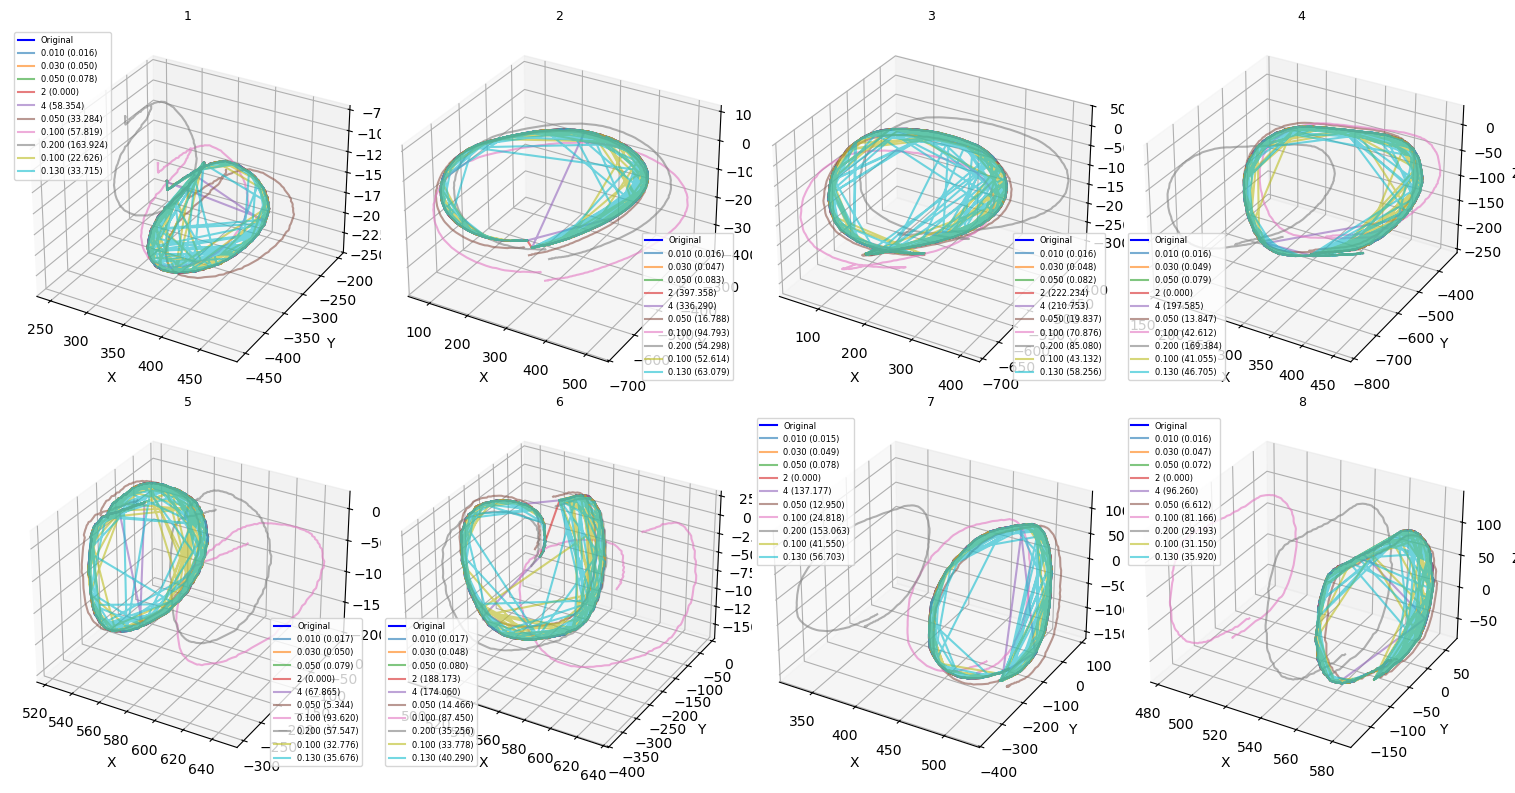


Displaying trajectories for folder : diagonal_left


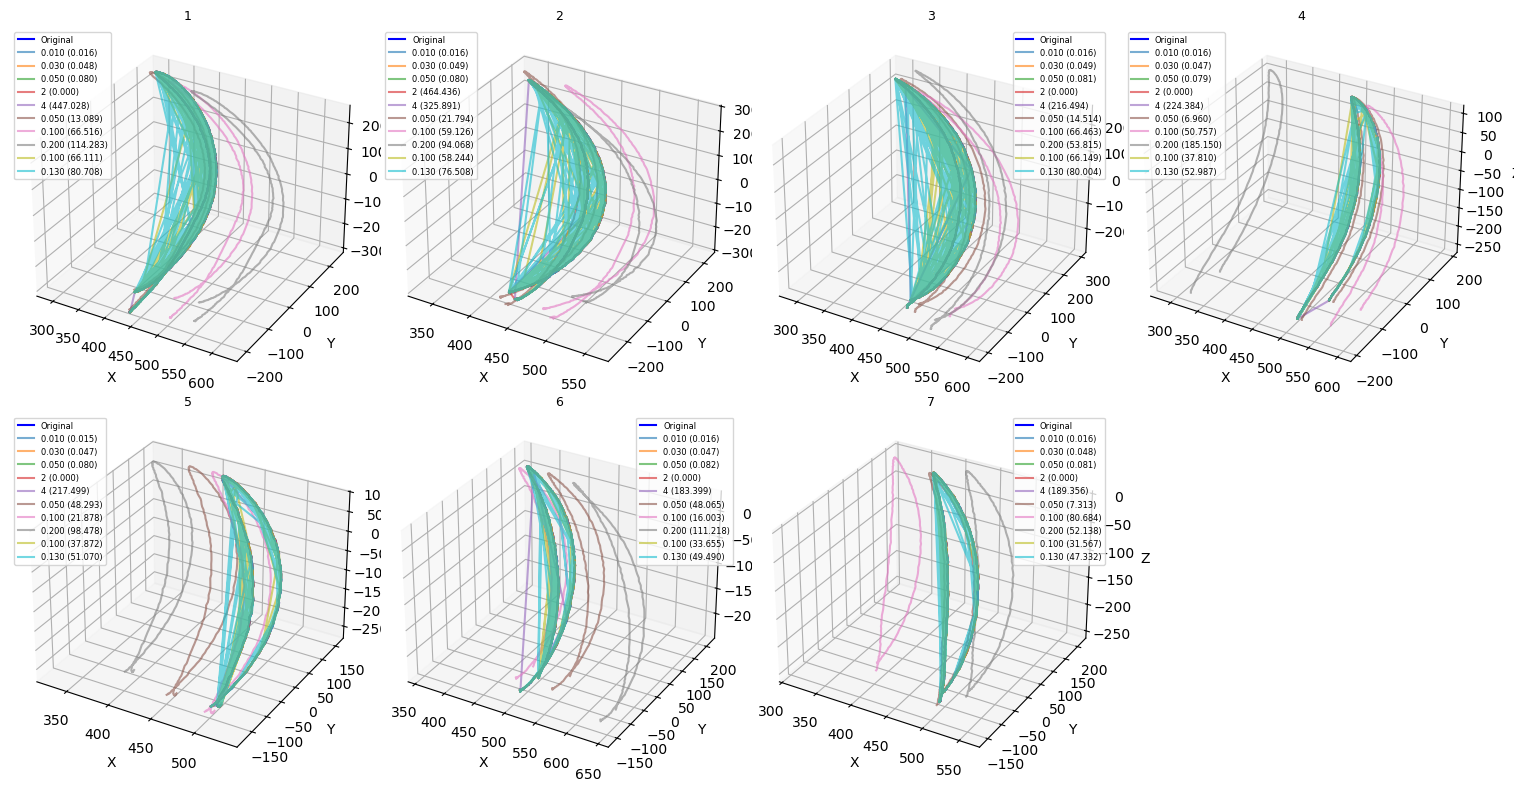


Displaying trajectories for folder : diagonal_right


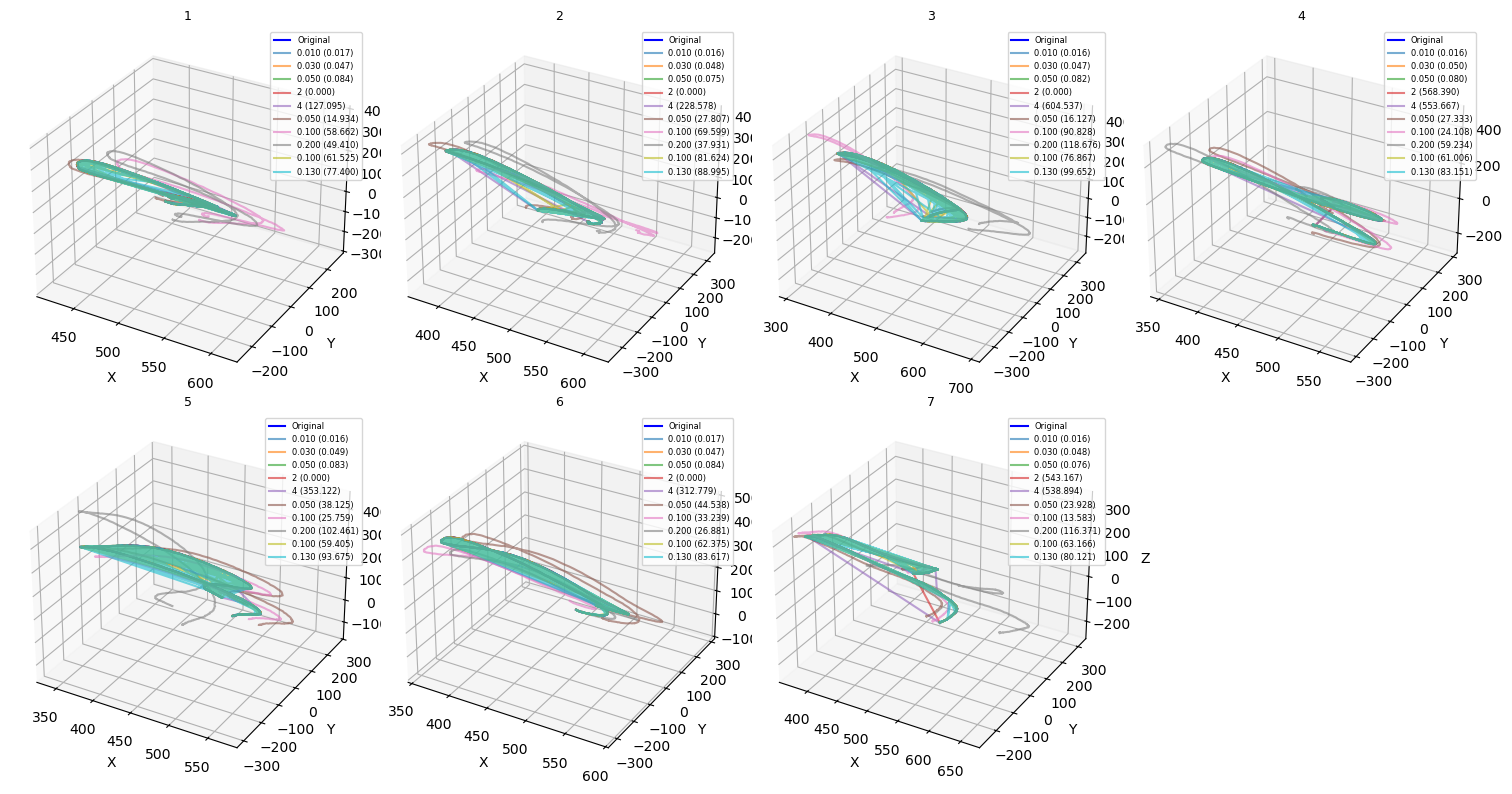


Displaying trajectories for folder : horizontal


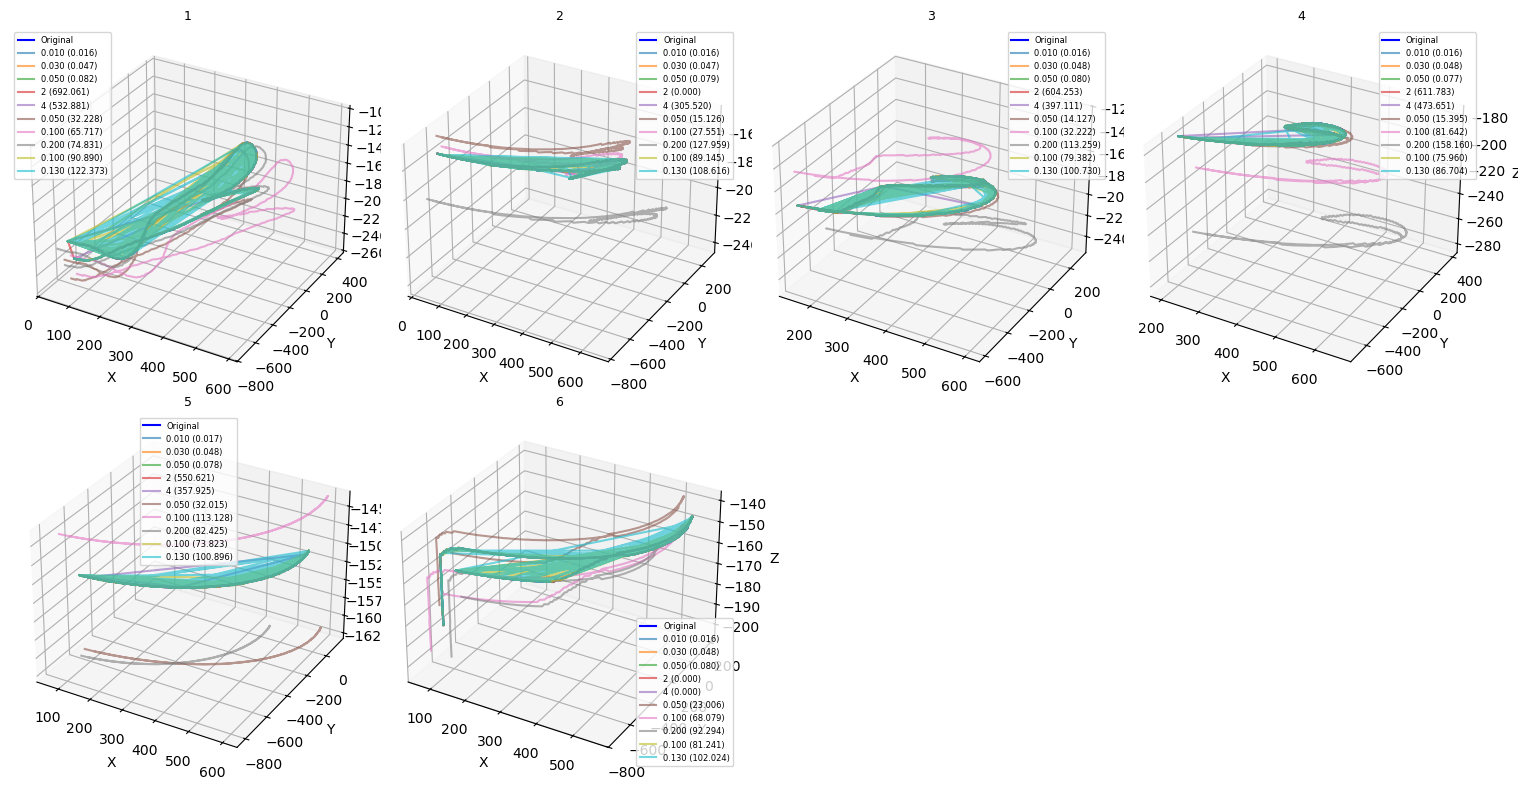


Displaying trajectories for folder : vertical


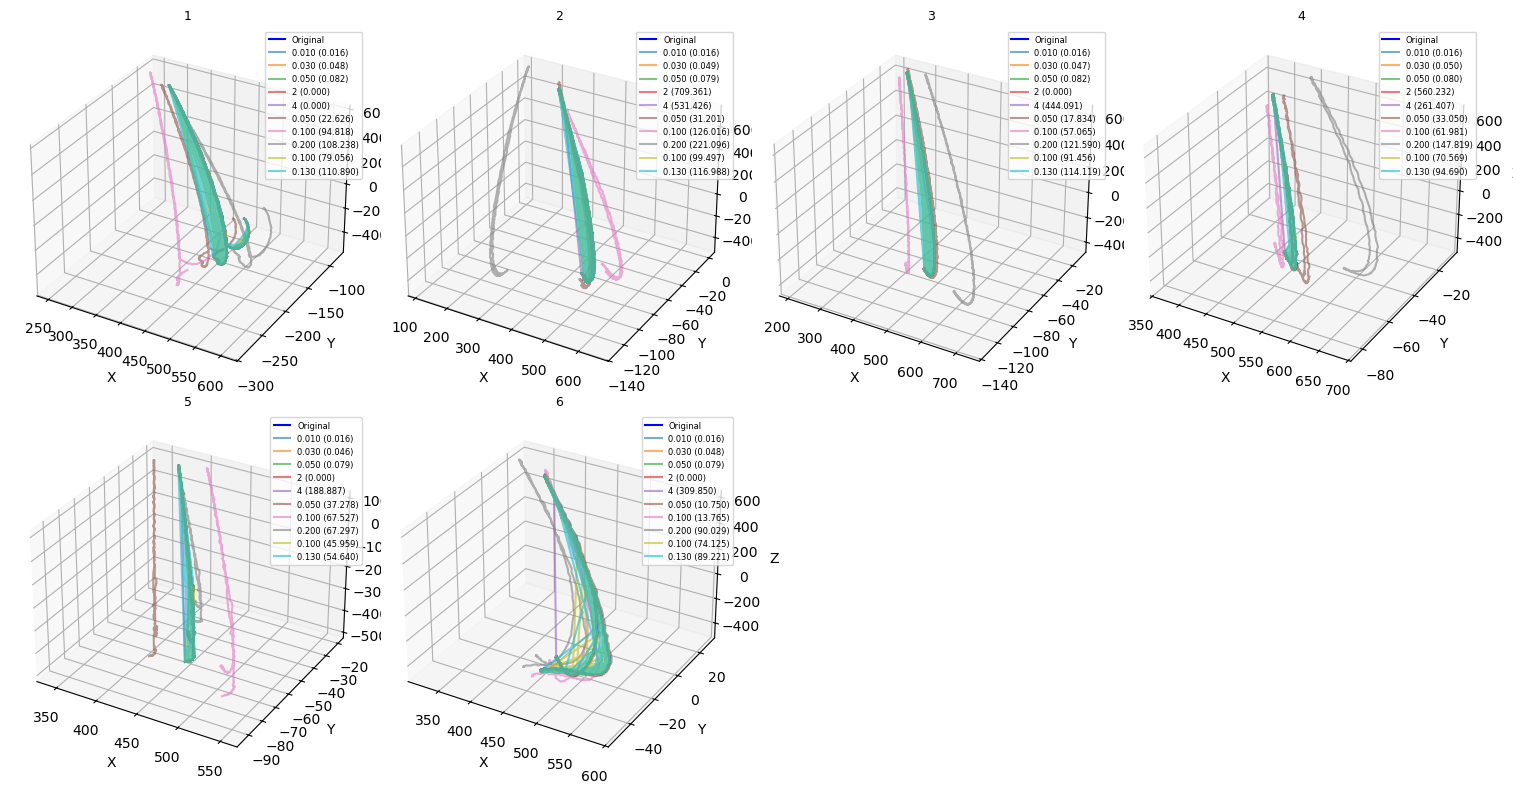

In [51]:
for folder_name in target_folders:
    class_path = os.path.join(base_path, folder_name)
    augmented_path = os.path.join(augmented_root, folder_name)

    if not os.path.isdir(class_path):
        print(f"Folder '{folder_name}' does not exist in {base_path}")
        continue

    file_list = glob.glob(os.path.join(class_path, "*.txt"))
    if not file_list:
        print(f"No files found in '{folder_name}'")
        continue

    print(f"\nDisplaying trajectories for folder : {folder_name}")

    n_files = len(file_list)
    n_cols = 4
    n_rows = int(np.ceil(n_files / n_cols))
    fig = plt.figure(figsize=(15, 4 * n_rows))

    def load_original(file_path):
        df = pd.read_csv(file_path, sep=",", header=None, comment="#")
        coords = df.iloc[:, 6].dropna().astype(str).str.split("/", expand=True).astype(float)
        coords.columns = ["x", "y", "z"]
        return coords.to_numpy()

    def load_augmented(file_path):
        return np.loadtxt(file_path, delimiter=",")

    def compute_score(original, augmented):
        min_len = min(len(original), len(augmented))
        return np.mean(np.linalg.norm(original[:min_len] - augmented[:min_len], axis=1))

    for i, file_path in enumerate(file_list, start=1):
        original_data = load_original(file_path)
        base_name = os.path.splitext(os.path.basename(file_path))[0]
        augmented_files = glob.glob(os.path.join(augmented_path, f"{base_name}_*.txt"))

        ax = fig.add_subplot(n_rows, n_cols, i, projection='3d')
        ax.plot(original_data[:,0], original_data[:,1], original_data[:,2], color='blue', label="Original")

        for aug_file in augmented_files:
            try:
                aug_data = load_augmented(aug_file)
                score = compute_score(original_data, aug_data)
                aug_type = os.path.basename(aug_file).split('_')[-2]
                ax.plot(aug_data[:,0], aug_data[:,1], aug_data[:,2], alpha=0.6, label=f"{aug_type} ({score:.3f})")
            except Exception as e:
                print(f"Error loading {aug_file}: {e}")

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title(base_name, fontsize=9)
        ax.legend(fontsize=6)

    plt.tight_layout()
    plt.show()